In [1]:
!pip install kaggle

In [2]:
# Move the uploaded API key to the appropriate folder
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
# Set appropriate permissions for the API key
!chmod 600 ~/.kaggle/kaggle.json
# Download the competition dataset
!kaggle competitions download -c cpe342-karena

 96% 888M/922M [00:04<00:00, 164MB/s]
100% 922M/922M [00:04<00:00, 219MB/s]


In [3]:
import zipfile
import os

zip_file_path = "/content/cpe342-karena.zip"
target_folder = "/content/datasets"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

print("Files extracted and appended to", target_folder)

Files extracted and appended to /content/datasets


In [7]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


## Load and Inspect Data

Load the raw training dataset and inspect its structure and summary statistics.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/content/datasets/public_dataset/task1/train.csv")

# Display the first 5 rows
print("First 5 rows of the dataframe:")
display(df.head())

# Check column types and non-null counts
print("\nDataFrame Info:")
df.info()

# Statistical summary of numerical columns
print("\nStatistical Summary:")
display(df.describe())

First 5 rows of the dataframe:


,id,player_id,kill_death_ratio,headshot_percentage,win_rate,accuracy_score,kill_consistency,reaction_time_ms,account_age_days,level,...,team_play_score,buy_decision_score,map_knowledge,clutch_success_rate,first_blood_rate,survival_time_avg,damage_per_round,utility_usage_rate,crosshair_placement,is_cheater
0,PLY00001,P058048,4.556072,15.494589,NaN,36.953785,0.737653,NaN,1204.586641,73.364603,...,0.653589,0.860407,0.487273,0.534021,0.321734,NaN,91.517681,0.736361,0.928522,0.0
1,PLY00002,P037400,6.177695,51.476210,86.670187,59.946064,NaN,93.748524,3.405453,84.104334,...,NaN,0.410925,0.690833,0.151872,0.462196,84.599562,119.212421,0.525739,0.946558,0.0
2,PLY00003,P001054,6.584511,51.692578,32.827778,46.545739,0.811803,120.895839,551.221686,43.803175,...,0.639732,0.619968,0.511507,0.311445,0.270611,83.793333,58.200726,0.739374,0.897872,0.0
3,PLY00004,P062710,5.237014,44.181842,62.740475,30.260066,0.345491,248.056545,114.034430,NaN,...,0.766887,0.612241,0.477374,NaN,0.402723,97.518653,121.315491,0.531533,0.860302,1.0
4,PLY00005,P068548,2.453744,44.361101,68.296046,27.470153,0.851962,210.530688,153.210944,83.293728,...,0.691935,0.653540,0.698389,NaN,0.197220,50.405967,79.110571,0.771739,0.853758,1.0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99872 entries, 0 to 99871
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       99872 non-null  object 
 1   player_id                99872 non-null  object 
 2   kill_death_ratio         97521 non-null  float64
 3   headshot_percentage      84716 non-null  float64
 4   win_rate                 90015 non-null  float64
 5   accuracy_score           96848 non-null  float64
 6   kill_consistency         97281 non-null  float64
 7   reaction_time_ms         73815 non-null  float64
 8   account_age_days         81323 non-null  float64
 9   level                    75795 non-null  float64
 10  level_progression_speed  80614 non-null  float64
 11  friend_network_size      91713 non-null  float64
 12  reports_received         75722 non-null  float64
 13  device_changes_count     90774 non-null  float64
 14  input

,kill_death_ratio,headshot_percentage,win_rate,accuracy_score,kill_consistency,reaction_time_ms,account_age_days,level,level_progression_speed,friend_network_size,...,team_play_score,buy_decision_score,map_knowledge,clutch_success_rate,first_blood_rate,survival_time_avg,damage_per_round,utility_usage_rate,crosshair_placement,is_cheater
count,97521.000000,84716.000000,90015.000000,96848.000000,97281.000000,73815.000000,81323.000000,75795.000000,80614.000000,91713.000000,...,84368.000000,92769.000000,93165.000000,74996.000000,97310.000000,83062.000000,88684.000000,97373.000000,93303.000000,97748.000000
mean,4.730992,47.862476,71.392377,40.136772,0.648417,135.095617,496.732778,62.834505,0.358055,138.040016,...,0.644913,0.595968,0.690491,0.339731,0.323232,66.212415,95.598928,0.579655,0.883145,0.349153
std,1.517649,13.809168,13.980314,12.132295,0.150941,51.168588,351.046370,20.713589,1.538594,84.928891,...,0.152952,0.156445,0.132566,0.138624,0.120221,24.287336,29.529363,0.173510,0.041532,0.476705
min,0.500000,5.000000,19.072048,8.000000,0.250000,55.000000,1.025164,25.000258,0.003612,0.000000,...,0.380002,0.235636,0.460000,0.100012,0.096278,8.414078,11.238571,0.280000,0.800002,0.000000
25%,3.707266,38.234664,61.712798,31.590962,0.543156,99.365908,158.319583,44.942872,0.040509,64.000000,...,0.512490,0.465125,0.576161,0.219427,0.219853,45.176432,70.545063,0.429521,0.848158,0.000000
50%,4.563780,47.136106,71.306532,39.582770,0.651803,128.520912,479.826280,62.886963,0.080959,136.000000,...,0.644465,0.588652,0.690222,0.339817,0.322364,66.206088,95.197261,0.579163,0.883225,0.000000
75%,5.535913,56.593599,81.002581,48.071852,0.756384,162.611524,763.609374,80.811109,0.210263,206.000000,...,0.778002,0.727212,0.805389,0.459482,0.424723,87.385053,120.543999,0.730082,0.918116,1.000000
max,12.000000,95.000000,100.000000,85.000000,0.980000,528.543010,1499.843118,99.999222,78.259728,349.000000,...,0.909999,0.879998,0.919991,0.579999,0.539995,107.999177,147.999111,0.879998,0.959998,1.000000


In [18]:
# Calculate missing values and percentages
missing_count = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

# Create a DataFrame to display missing value statistics
missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percent
}).sort_values(by='Missing Percentage', ascending=False)

# Check for duplicate rows
duplicates_count = df.duplicated().sum()

print(f"Number of duplicate rows: {duplicates_count}")
print("\nMissing Values Summary:")
display(missing_df.head(5))

# Check specifically for missing target values
missing_target = df['is_cheater'].isnull().sum()
print(f"\nMissing values in target 'is_cheater': {missing_target} ({missing_target/len(df)*100:.2f}%)")

Number of duplicate rows: 0

Missing Values Summary:


,Missing Count,Missing Percentage
reaction_time_ms,26057,26.090396
clutch_success_rate,24876,24.907882
reports_received,24150,24.180952
level,24077,24.107858
movement_pattern_score,23872,23.902595



Missing values in target 'is_cheater': 2124 (2.13%)


**Discuss**:
Visualize distributions and boxplots of key numerical features (kill_death_ratio, headshot_percentage, win_rate) to identify patterns and detect outliers as per the EDA plan.



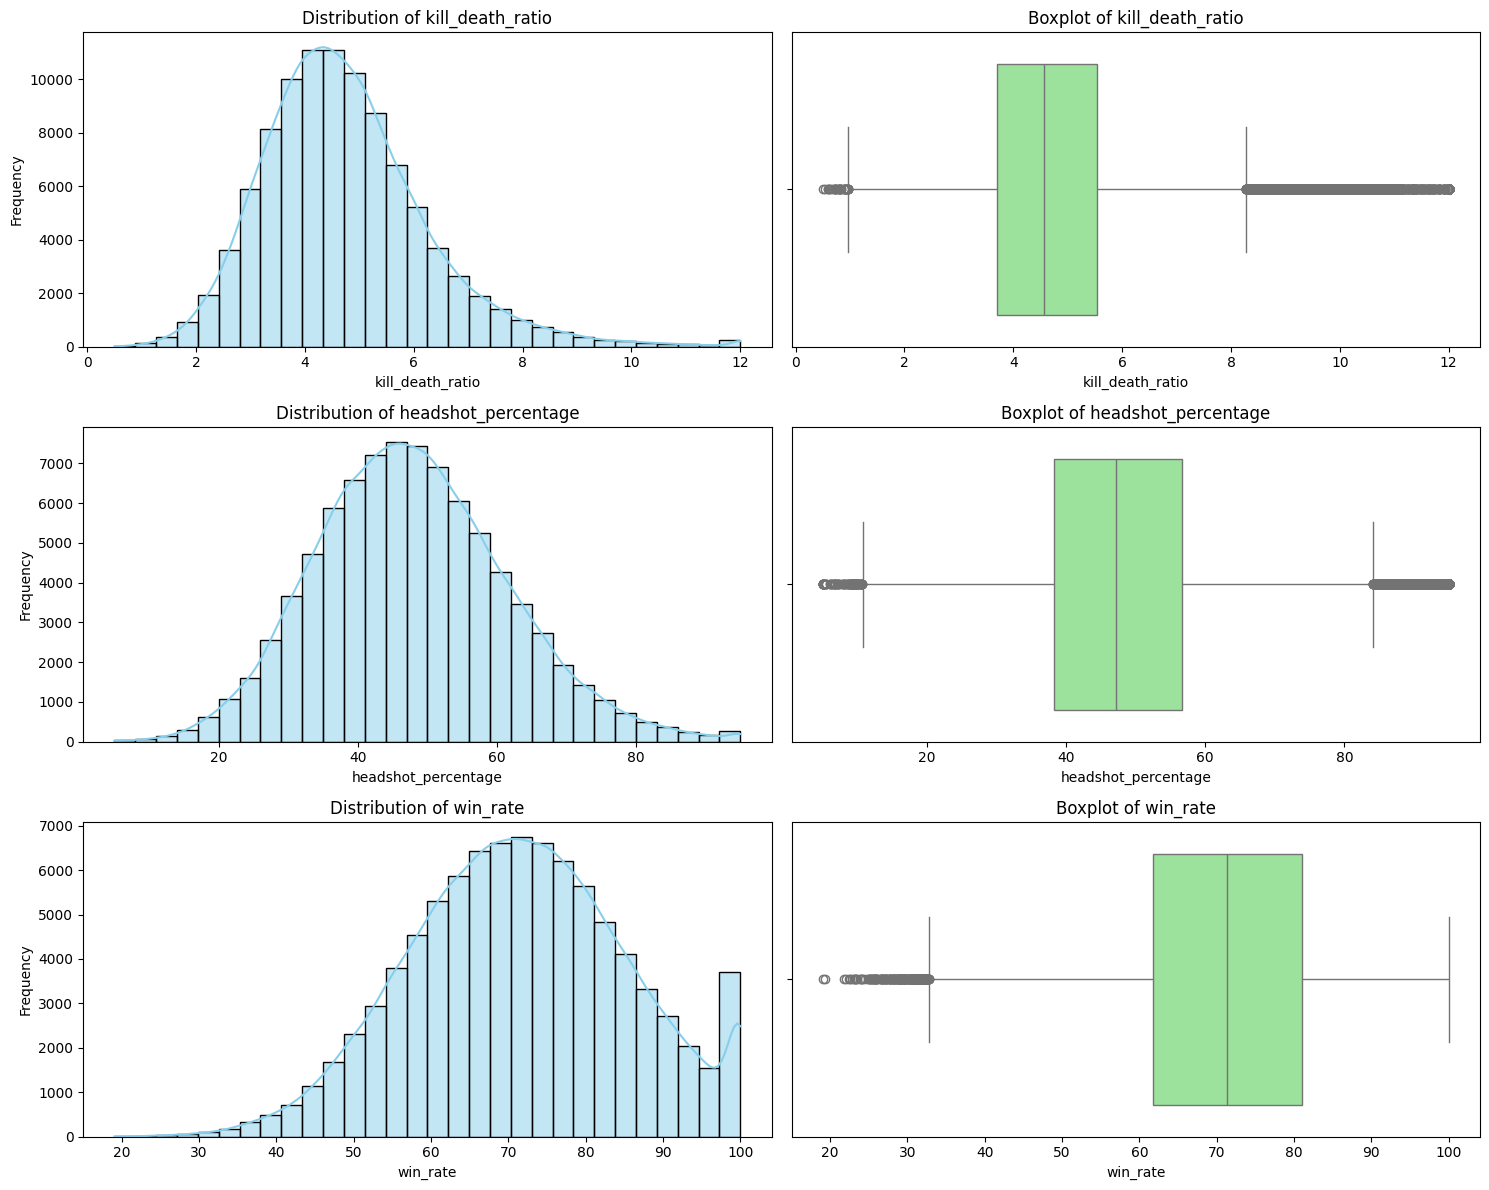

In [11]:
features_to_plot = ['kill_death_ratio', 'headshot_percentage', 'win_rate']

plt.figure(figsize=(15, 12))

for i, feature in enumerate(features_to_plot):
    # Histogram with KDE
    plt.subplot(3, 2, 2*i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(3, 2, 2*i + 2)
    sns.boxplot(x=df[feature], color='lightgreen')
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

**Discuss**:
Compute and visualize correlations between numerical features and the target 'is_cheater' to identify strong predictors, as per step 4 of the EDA plan.



Top 10 features correlated with 'is_cheater':


,is_cheater
reports_received,-0.335051
crosshair_placement,-0.235358
headshot_percentage,-0.135119
kill_death_ratio,-0.129590
game_sense_score,-0.125044
account_age_days,-0.099350
accuracy_score,-0.094060
level,-0.079039
spray_control_score,-0.073448
friend_network_size,-0.070433


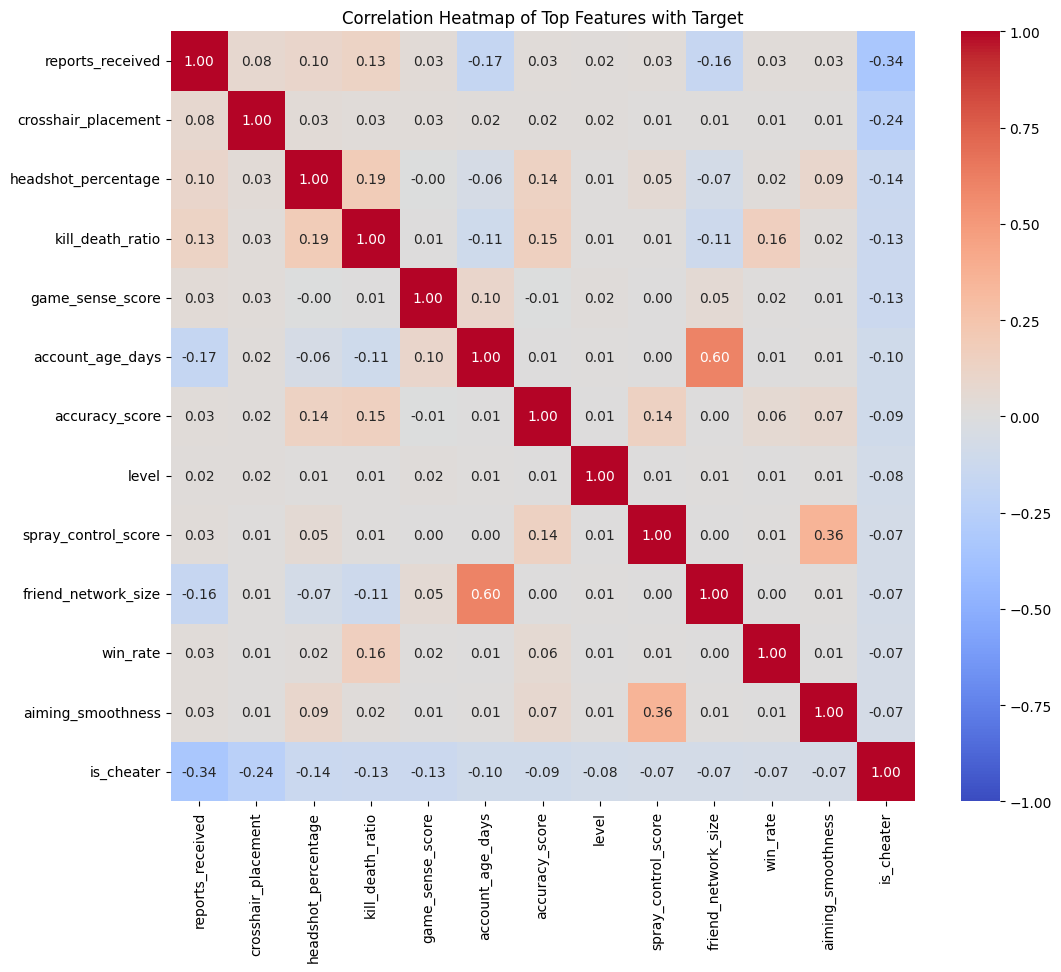

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix for numerical columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

# Get correlation with the target
target_correlation = corr_matrix['is_cheater'].drop('is_cheater')

# Sort by absolute value to see strongest relationships (both positive and negative)
sorted_corr = target_correlation.iloc[target_correlation.abs().argsort()[::-1]]

print("Top 10 features correlated with 'is_cheater':")
display(sorted_corr.head(10))

# Select top 12 features for the heatmap
top_features_list = sorted_corr.head(12).index.tolist()
heatmap_data = df[top_features_list + ['is_cheater']].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Top Features with Target')
plt.show()

**Discuss**:
Compare feature distributions for Cheaters vs. Non-Cheaters to identify distinguishing patterns, focusing on top correlated features.



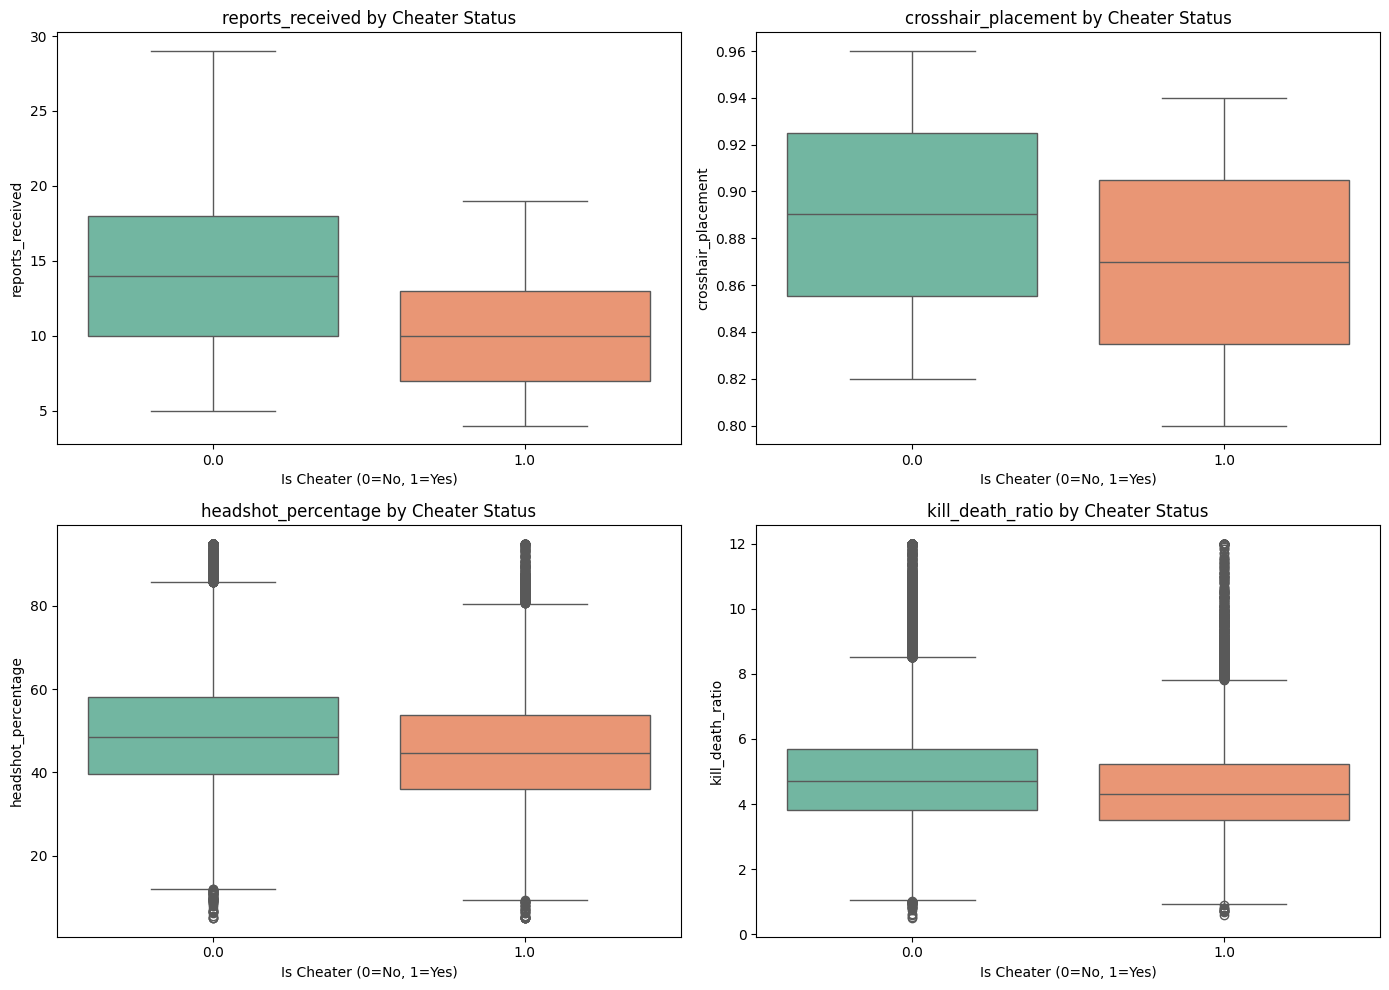

In [14]:
features_to_compare = ['reports_received', 'crosshair_placement', 'headshot_percentage', 'kill_death_ratio']

plt.figure(figsize=(14, 10))

for i, feature in enumerate(features_to_compare):
    plt.subplot(2, 2, i + 1)
    # Assign x to hue to avoid FutureWarning with palette
    sns.boxplot(x='is_cheater', y=feature, data=df, hue='is_cheater', legend=False, palette='Set2')
    plt.title(f'{feature} by Cheater Status')
    plt.xlabel('Is Cheater (0=No, 1=Yes)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# Training Model

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool

# ==========================================================
# LOAD TRAIN/TEST
# ==========================================================
train = pd.read_csv("/content/datasets/public_dataset/task1/train.csv")
test  = pd.read_csv("/content/datasets/public_dataset/task1/test.csv")
answer = pd.read_csv("final_answer_task2_catboost.csv")

# ==========================================================
# CLEAN TARGET
# ==========================================================
train = train.dropna(subset=["is_cheater"]).reset_index(drop=True)
y = train["is_cheater"].astype(int)

# ==========================================================
# DROP NON-FEATURE COLUMNS (ID Columns)
# detect object columns that are NOT real features
# ==========================================================
# find all object columns
obj_cols = train.select_dtypes(include=["object"]).columns.tolist()

print("Object columns detected:", obj_cols)

# usually these include player_id or similar → remove from training
train = train.drop(columns=obj_cols)
test  = test.drop(columns=obj_cols)

# ==========================================================
# DEFINE FEATURES (NUMERIC ONLY)
# ==========================================================
X = train.drop(columns=["is_cheater"])
X_test = test.copy()

# fill numeric NaN
X = X.fillna(X.median())
X_test = X_test.fillna(X.median())

# ==========================================================
# 5-FOLD STRATIFIED CV
# ==========================================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

test_pred_proba = np.zeros(len(X_test))
oof_pred = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"\n===== Training Fold {fold+1} =====")

    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

    train_pool = Pool(X_tr, y_tr)
    valid_pool = Pool(X_val, y_val)
    test_pool  = Pool(X_test)

    model = CatBoostClassifier(
        iterations=2000,
        depth=9,
        learning_rate=0.02,
        l2_leaf_reg=5,
        random_seed=42,
        loss_function="Logloss",
        eval_metric="AUC",
        od_type="Iter",
        od_wait=80,
        verbose=200
    )

    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    oof_pred[valid_idx] = model.predict_proba(valid_pool)[:, 1]
    test_pred_proba += model.predict_proba(test_pool)[:, 1] / 5

# ==========================================================
# FINAL PREDICTION
# ==========================================================
test_pred = (test_pred_proba >= 0.5).astype(int)

# ==========================================================
# UPDATE ANSWER FILE (TASK1)
# ==========================================================
answer = answer.sort_values("id").reset_index(drop=True)
answer["task1"] = test_pred

answer.to_csv("./final_answer_task1_catboost_clean.csv", index=False)
print("\nSaved → final_answer_task1_catboost_clean.csv")

Object columns detected: ['id', 'player_id']

===== Training Fold 1 =====
0:	test: 0.7819973	best: 0.7819973 (0)	total: 275ms	remaining: 9m 10s
200:	test: 0.8878521	best: 0.8878764 (193)	total: 18.8s	remaining: 2m 48s
400:	test: 0.8914644	best: 0.8914644 (400)	total: 36.8s	remaining: 2m 26s
600:	test: 0.8933521	best: 0.8933521 (600)	total: 54.4s	remaining: 2m 6s
800:	test: 0.8943947	best: 0.8944135 (785)	total: 1m 14s	remaining: 1m 51s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.8945820518
bestIteration = 882

Shrink model to first 883 iterations.

===== Training Fold 2 =====
0:	test: 0.7844834	best: 0.7844834 (0)	total: 92.9ms	remaining: 3m 5s
200:	test: 0.8885773	best: 0.8886134 (199)	total: 19.1s	remaining: 2m 51s
400:	test: 0.8923670	best: 0.8923818 (395)	total: 36.9s	remaining: 2m 26s
600:	test: 0.8940604	best: 0.8940604 (600)	total: 56.2s	remaining: 2m 10s
800:	test: 0.8959428	best: 0.8959752 (795)	total: 1m 16s	remaining: 1m 54s
1000:	test: 0.8962635	best

In [16]:
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC score
oof_auc = roc_auc_score(y, oof_pred)

print(f"Overall OOF ROC AUC Score: {oof_auc:.5f}")

Overall OOF ROC AUC Score: 0.89622


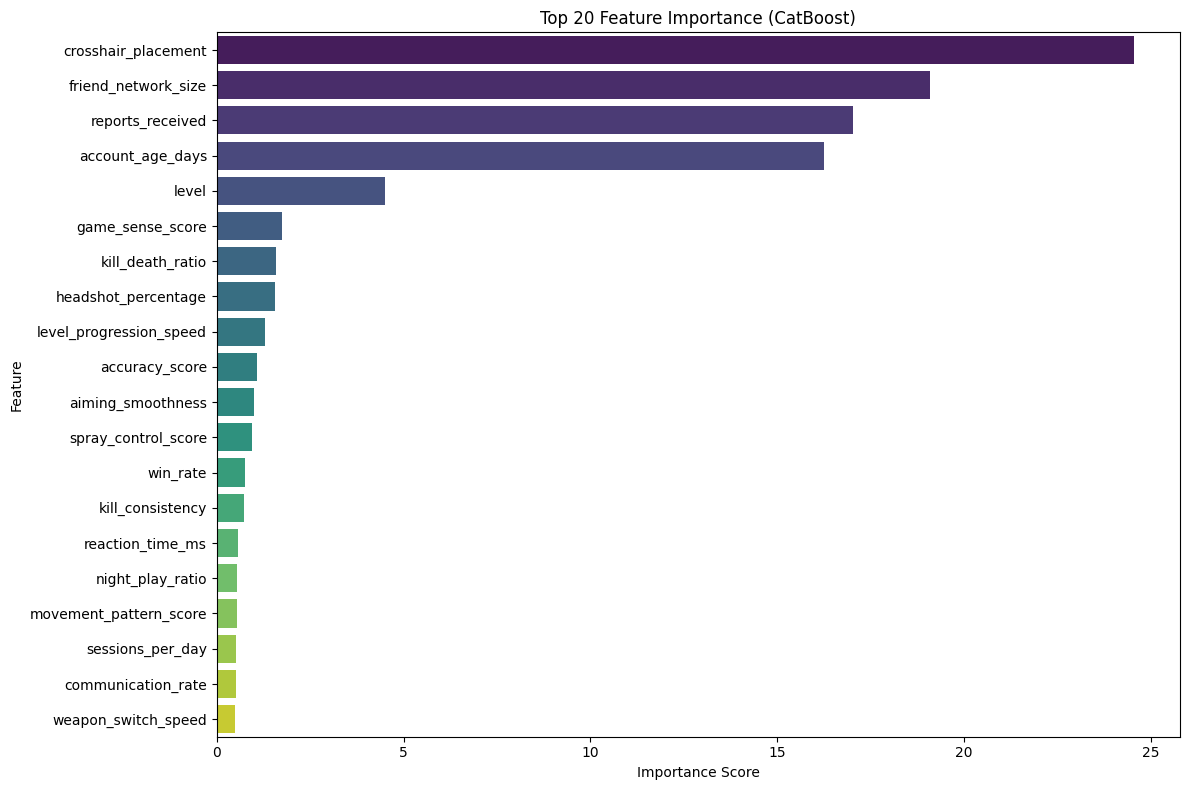

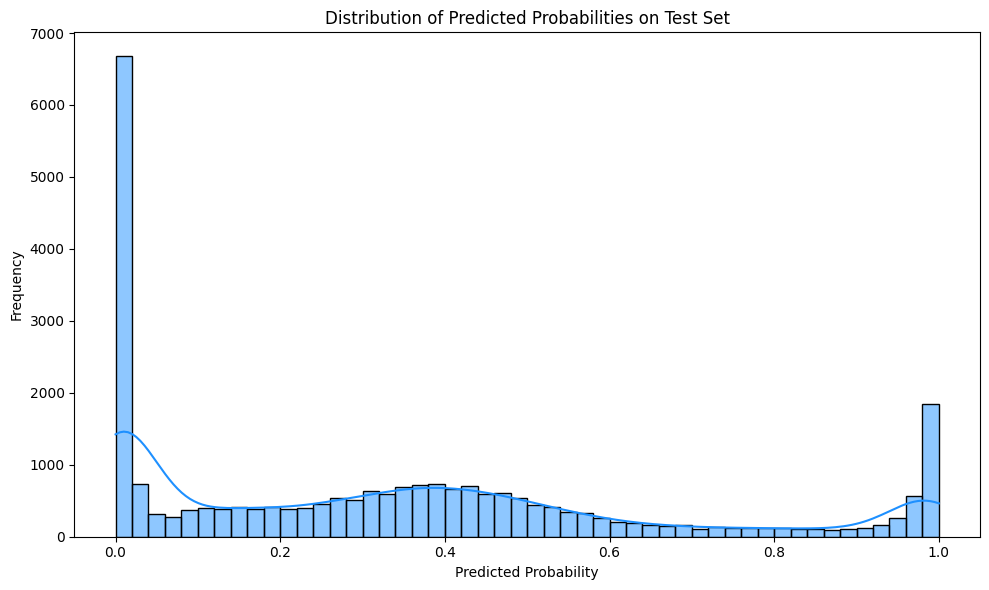

In [17]:
# Get feature importance from the model
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame for visualization
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False).head(20)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis', hue='feature', legend=False)
plt.title('Top 20 Feature Importance (CatBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Plot Distribution of Predicted Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(test_pred_proba, kde=True, bins=50, color='dodgerblue')
plt.title('Distribution of Predicted Probabilities on Test Set')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Data Analysis Key Findings

- **Model Performance:** The evaluation of the CatBoost model using out-of-fold predictions resulted in a robust ROC AUC score of **0.89622**.
- **Feature Importance:** The analysis successfully extracted and visualized the top 20 most important features, highlighting the primary drivers of the model's decision-making process.
- **Prediction Distribution:** A histogram was generated for the predicted probabilities on the test set, allowing for an assessment of the model's confidence levels and the spread of prediction values.

